In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

import os
import gzip
import json
import pickle
import pandas as pd

from serpapi import GoogleSearch


In [26]:
def load_topics(topics_path='./data/topics_linked.csv.xz'):
    df_topics = pd.read_csv(topics_path, compression="infer")
    topics = df_topics.columns[1:-1]
    return df_topics, sorted(list(topics))


def load_interventions(interventions_path='./data/interventions.csv'):
    # Loads intervention
    interventions_df = pd.read_csv(interventions_path,sep = ';')
    for col in interventions_df.columns:
        if col != "lang":
            interventions_df.loc[:, col] = pd.to_datetime(interventions_df.loc[:, col])
    interventions = {}
    for _, lang_info in interventions_df.T.to_dict().items():
        lang = lang_info['lang']
        del lang_info['lang']
        interventions[lang] = {k: t for k, t in lang_info.items() if not pd.isnull(t)}
    return interventions

def load_pca(codes_order, pca_folder="./data/pca/"):
    dfs_pca_shift = {}
    for lang in codes_order:
        path = os.path.join(pca_folder, '_'.join([lang + '.comb', 'PCA', 'shift.f']))
        df = pd.read_feather(path).set_index('index')
        df.index = pd.to_datetime(df.index)
        dfs_pca_shift[lang] = df
    return dfs_pca_shift


def load_aggregated(aggregated_path="./data/aggregated.p"):
    if aggregated_path.endswith(".gz"):
        with gzip.open(aggregated_path, "rb") as f:
            agg = json.loads(f.read().decode())
    else:
        with open(aggregated_path, "rb") as f:
            agg = pickle.load(f)

    for k1, i1 in agg.items():
        for k2, i2 in agg[k1].items():
            if type(agg[k1][k2]) == pd.Series:
                agg[k1][k2].index = pd.to_datetime(agg[k1][k2].index, errors="ignore")
            elif (type(agg[k1][k2]) == dict) and len(list(agg[k1][k2].keys())) > 100:
                agg[k1][k2] = pd.Series(agg[k1][k2])
                agg[k1][k2].index = pd.to_datetime(agg[k1][k2].index, errors="ignore")
            elif type(agg[k1][k2]) == dict:
                for k3, i3 in agg[k1][k2].items():
                    if type(agg[k1][k2][k3]) == pd.Series:
                        agg[k1][k2][k3].index = pd.to_datetime(agg[k1][k2][k3].index, errors="ignore")
                    elif (type(agg[k1][k2][k3]) == dict) and len(list(agg[k1][k2][k3].keys())) > 100:
                        agg[k1][k2][k3] = pd.Series(agg[k1][k2][k3])
                        agg[k1][k2][k3].index = pd.to_datetime(agg[k1][k2][k3].index, errors="ignore")
                    elif type(agg[k1][k2][k3]) == dict:
                        for k4, i4 in agg[k1][k2][k3].items():
                            if type(agg[k1][k2][k3][k4]) == pd.Series:
                                agg[k1][k2][k3][k4].index = pd.to_datetime(agg[k1][k2][k3][k4].index, errors="ignore")
                            elif (type(agg[k1][k2][k3][k4]) == dict) and len(list(agg[k1][k2][k3][k4].keys())) > 100:
                                agg[k1][k2][k3][k4] = pd.Series(agg[k1][k2][k3][k4])
                                agg[k1][k2][k3][k4].index = pd.to_datetime(agg[k1][k2][k3][k4].index, errors="ignore")
    return agg

def load_gtrend_df(pagename, filename):
    trend_data = []
    month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

    with open(filename, 'r') as file:
        gtrends_dict = json.load(file)

        dates = []
        for data in gtrends_dict['interest_over_time']['timeline_data']:
            parts = data['date'].replace('–', ' '). replace(',', ' ').split()    
            dates.append(datetime(year=int(parts[2 if len(parts) == 6 else -1]), 
                                    month=month_mapping[parts[0]], 
                                    day=int(parts[1])))

        views = []
        topics = [data['query'] for data in gtrends_dict['interest_over_time']['averages']]
        for i in range(len(topics)):
            views.append([int(data['values'][i]['value']) for data in gtrends_dict['interest_over_time']['timeline_data']])
        
        gtrends_df = pd.DataFrame({'Date': dates, topics[0]: views[0], topics[1]: views[1], topics[2]: views[2], topics[3]: views[3], topics[4]: views[4]})
        gtrends_df.set_index('Date', inplace=True)

    return gtrends_df

## Initial analysis
Making some plot to show how during the pandemic, as the mobility decreased, the online traffic increase, there should be a inverse correlation

In [27]:
# Importing mobility reports, 
google_df = pd.read_csv('./data/Global_Mobility_Report.csv.gz', compression="infer")
apple_df = pd.read_csv('./data/applemobilitytrends-2020-04-20.csv.gz', compression="infer")

/tmp/ipykernel_22275/3973189245.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  google_df = pd.read_csv('./data/Global_Mobility_Report.csv.gz', compression="infer")


In [28]:
# We're only interested in the US, so we keep only the component about the US
mobility_us_df = google_df[google_df.country_region_code == 'US'].drop(columns=['country_region', 'country_region_code']).copy()
mobility_us_df['date'] = pd.to_datetime(mobility_us_df['date'])
# mobility_us_df = mobility_us_df.set_index('date')

# We're interested in the complete and states values, so we can discard the the values for which sub_region_2 is not null
mobility_us_df = mobility_us_df[mobility_us_df.sub_region_2.isna()].drop(columns=['sub_region_2','metro_area','iso_3166_2_code','census_fips_code'])

Interesting consideration, there is a difference between the change in mobility during the week (where people always go out for working) and during the weekend (where also normally people sometimes stay at home), this is clear looking at the daily plot, so it's beneficial to use the weekly one instead

In [29]:
# It's a little trickier than in other states as different states had different responses and dates, we can take some example cases

# California, stay at home on March 19, 2020, lifted on May 7, 2020
general_df = mobility_us_df[(mobility_us_df.sub_region_1.isna()) & (general_df.date >= datetime(year=2020, month=2, day=15)) & (general_df.date <= datetime(year=2020, month=7, day=15))]
weekly_general_df = general_df.resample('W-Mon', on='date').apply(lambda x: x.residential_percent_change_from_baseline.mean())

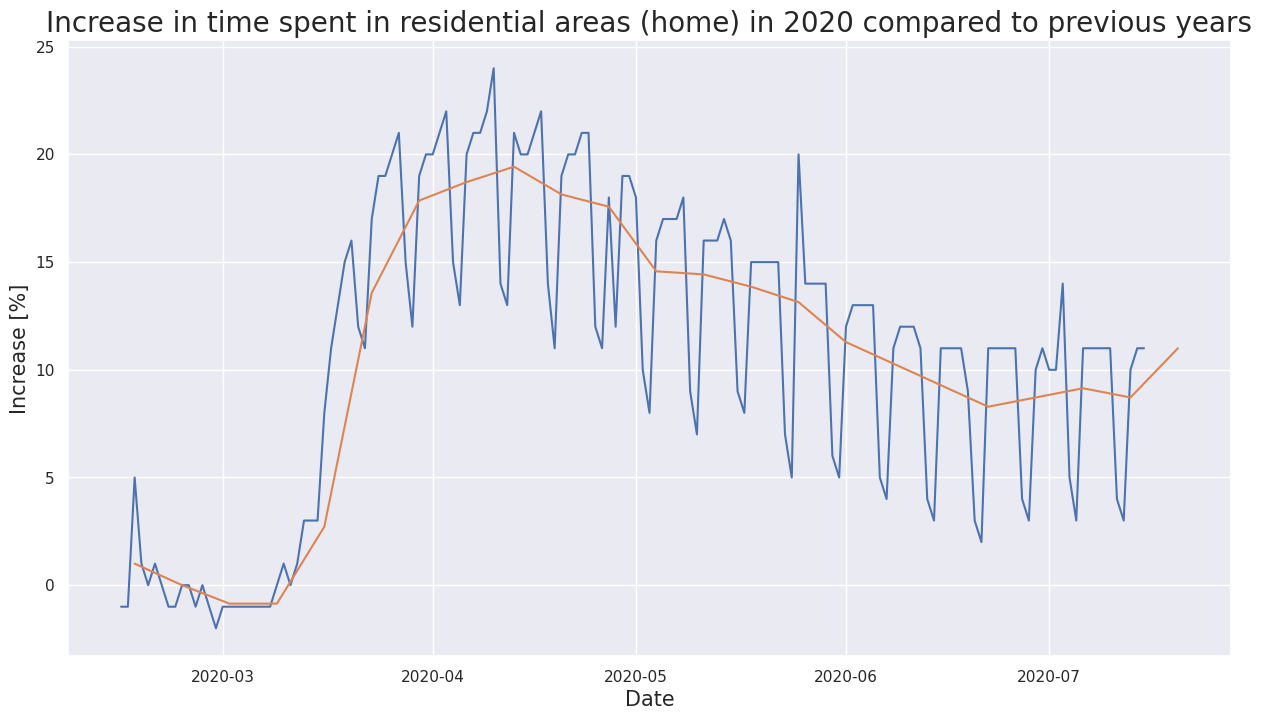

In [30]:
plt.title('Increase in time spent in residential areas (home) in 2020 compared to previous years', size=20)
plt.ylabel('Increase [%]', size=15)
plt.xlabel('Date', size=15)
plt.plot(general_df.date, general_df.residential_percent_change_from_baseline)
plt.plot(weekly_general_df)
#plt.xticks([datetime(year=2020, month=m, day=1).strftime('%Y-%m') for m in np.arange(2,7)])

Now let's take the number of searches over time, we want to measure the total number of searches. One way to solve the problem is to make queries on different uncorrelated topics, the general consumption can be found by averaging the different topics.

In [31]:
# Import result from search
timeseries_dict = load_aggregated('./data/aggregated_timeseries.json.gz')

In [32]:
decrease_factor = ((np.array(timeseries_dict['en']['sum'].loc[datetime(year=2018, month=2, day=17):datetime(year=2018, month=7, day=18)]) \
                   - np.array(timeseries_dict['en']['sum'].loc[datetime(year=2019, month=2, day=16):datetime(year=2019, month=7, day=17)])) \
                   / np.array(timeseries_dict['en']['sum'].loc[datetime(year=2019, month=2, day=16):datetime(year=2019, month=7, day=17)])).mean()

In [33]:
total_searches_before = (np.array(timeseries_dict['en']['sum'].loc[datetime(year=2018, month=2, day=17):datetime(year=2018, month=7, day=18)]) \
                       + np.array(timeseries_dict['en']['sum'].loc[datetime(year=2019, month=2, day=16):datetime(year=2019, month=7, day=17)] * (1 + decrease_factor))) / 2
total_searches_2020 = np.array(timeseries_dict['en']['sum'].loc[datetime(year=2020, month=2, day=15):datetime(year=2020, month=7, day=15)]) * (1 + decrease_factor)**2
total_searches_increase = 100 * (total_searches_2020 / total_searches_before - 1)

date_range = pd.date_range(datetime(year=2020, month=2, day=15), datetime(year=2020, month=7, day=15))

total_searches_increase = pd.DataFrame({'date': date_range, 'increase': total_searches_increase})#.set_index('date')
weekday_searches_increase = total_searches_increase[total_searches_increase.date.dt.weekday > 4]

total_searches_increase = total_searches_increase.set_index('date')
weekly_total_searches_increase = total_searches_increase.resample('W-Mon').mean()

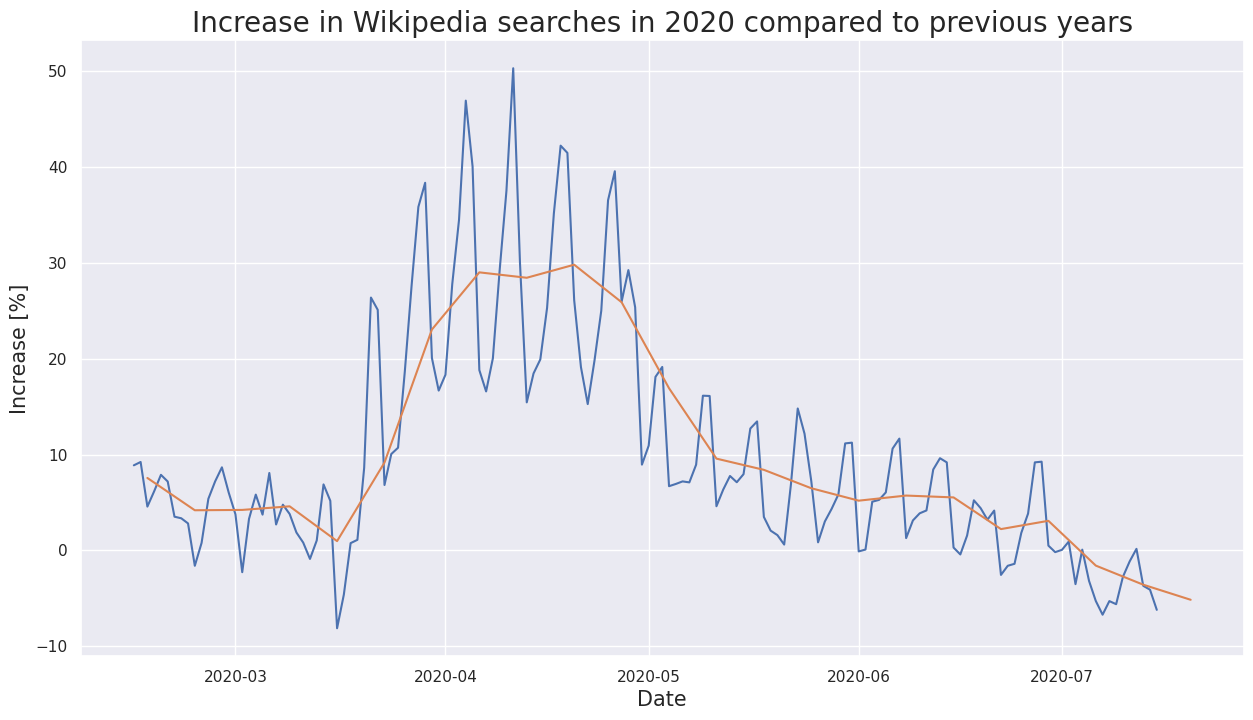

In [34]:
plt.title('Increase in Wikipedia searches in 2020 compared to previous years', size=20)
plt.ylabel('Increase [%]', size=15)
plt.xlabel('Date', size=15)
plt.plot(total_searches_increase)
plt.plot(weekly_total_searches_increase)

Putting in context: the popularity of wikipedia from 2018 to 2020 has decreased, it can be seen by checking out the evolution of the weekly number of searches in the three years.

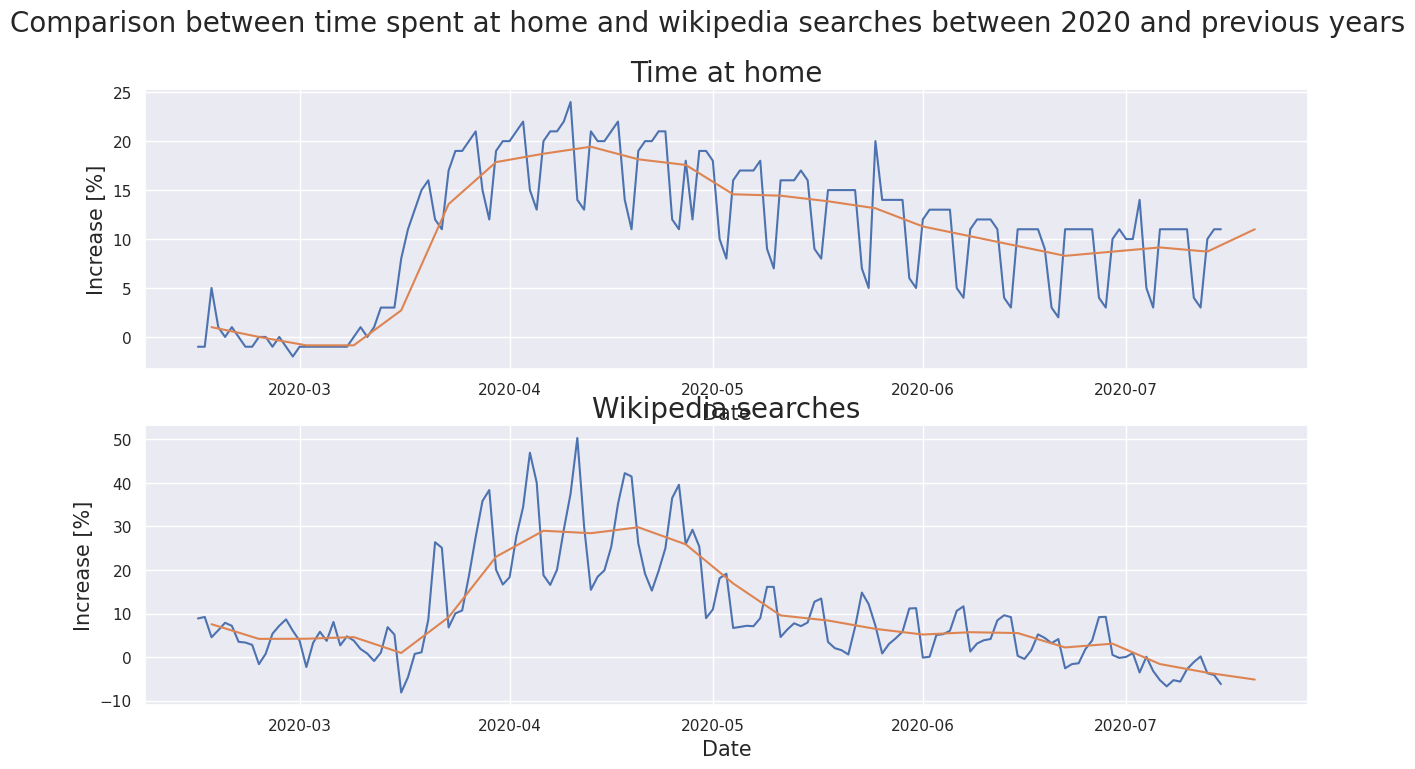

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=2)

general_df = general_df

fig.suptitle('Comparison between time spent at home and wikipedia searches between 2020 and previous years', size=20)
ax[0].set_title('Time at home', size=20)
ax[0].set_ylabel('Increase [%]', size=15)
ax[0].set_xlabel('Date', size=15)
ax[0].plot(general_df.date, general_df.residential_percent_change_from_baseline)
ax[0].plot(weekly_general_df)

ax[1].set_title('Wikipedia searches', size=20)
ax[1].set_ylabel('Increase [%]', size=15)
ax[1].set_xlabel('Date', size=15)
ax[1].plot(total_searches_increase)
ax[1].plot(weekly_total_searches_increase)

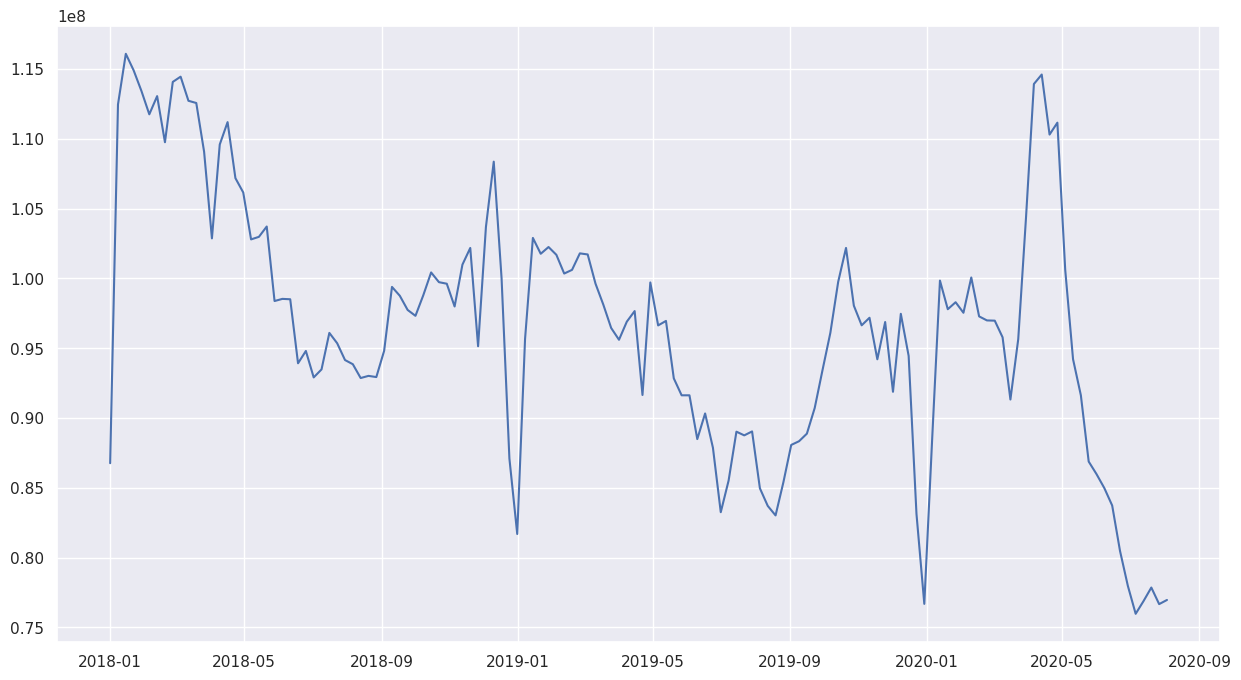

In [36]:
weekly_total_searches = timeseries_dict['en']['sum'].resample('W-Mon').mean()
plt.plot(weekly_total_searches)